In [1]:
!pip install gdown
!pip install unzip
!pip install tensorflow
!pip install PIL
!pip install pydot
!pip install pathlib
!pip install keras

  Preparing metadata (setup.py) ... - done
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1280 sha256=71cfe1ad04a3ec54cda248efd6c94088ed2437868f0ea071b40da732bc709357
  Stored in directory: /root/.cache/pip/wheels/80/dc/7a/f8af45bc239e7933509183f038ea8d46f3610aab82b35369f4
Successfully built unzip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [2]:
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot
from tensorflow.keras.models import Model
import PIL
import PIL.Image
import gdown
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

2024-06-04 12:34:26.079473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 12:34:26.079615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 12:34:26.263859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!gdown --id 1YCYOnlJgBU_uHqEgNYOJi4BxR2PUHboO

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YCYOnlJgBU_uHqEgNYOJi4BxR2PUHboO
To: /kaggle/working/Patches.zip
100%|██████████████████████████████████████| 23.0M/23.0M [00:00<00:00, 58.0MB/s]


In [4]:
!unzip -q './Patches.zip'

In [5]:
data_dir = pathlib.Path("./Patches")

In [6]:
batch_size = 64
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 1222 files belonging to 3 classes.
Using 978 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 1222 files belonging to 3 classes.
Using 244 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Abnormal(Ulcer)', 'Normal(Healthy skin)', 'Wound Images']


In [10]:
img_augmentation_layers =tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
])


In [11]:
# def format_label(label):
#     string_label = label_info.int2str(label)
#     return string_label.split("-")[1]

# label_info = train_ds.class_names
# for image, _ in train_ds.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = img_augmentation_layers(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [12]:
train_ds = train_ds.map(
    lambda x, y: (img_augmentation_layers(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [13]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [14]:
class customcallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99):
            print("\naccuracy >   0.99")
            self.model.stop_training = True

In [15]:
def build_model(num_classes):
    inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))
    model = MobileNetV3Large(include_top=False, input_tensor=inputs, weights='imagenet')

    model.trainable = False
    
    x = tf.keras.layers.GlobalMaxPool2D(name="max_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=4e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

12683000/12683000 [==============================] - 1s 0us/step
Epoch 1/100
16/16 [==============================] - 38s 2s/step - loss: 0.3454 - accuracy: 0.8855 - val_loss: 1.6988 - val_accuracy: 0.7705 - lr: 0.0040
Epoch 2/100
16/16 [==============================] - 31s 2s/step - loss: 0.1614 - accuracy: 0.9468 - val_loss: 0.8576 - val_accuracy: 0.8648 - lr: 0.0040
Epoch 3/100
16/16 [==============================] - 31s 2s/step - loss: 0.1516 - accuracy: 0.9519 - val_loss: 0.4972 - val_accuracy: 0.9262 - lr: 0.0040
Epoch 4/100
16/16 [==============================] - 30s 2s/step - loss: 0.1539 - accuracy: 0.9519 - val_loss: 0.3776 - val_accuracy: 0.9303 - lr: 0.0040
Epoch 5/100
16/16 [==============================] - 30s 2s/step - loss: 0.0912 - accuracy: 0.9601 - val_loss: 0.4411 - val_accuracy: 0.9344 - lr: 0.0040
Epoch 6/100
16/16 [==============================] - 31s 2s/step - loss: 0.0993 - accuracy: 0.9652 - val_loss: 0.2970 - val_accuracy: 0.9385 - lr: 0.0040
Epoch 7/100

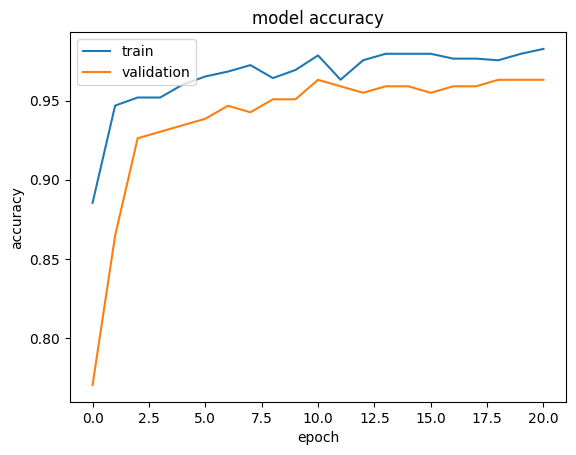

In [17]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping
# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(64, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(128  , 3, activation='relu'),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(3, activation='softmax')
# ])
model = build_model(num_classes=3)
callback = customcallback()
early_stopping = EarlyStopping(monitor='accuracy',min_delta=1,verbose=1, patience=3)
epochs = 100
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[early_stopper, reduce_lr])
plot_hist(hist)

In [18]:
# model.compile(
#   optimizer='adam',
#   loss='categorical_crossentropy',
#   metrics=['accuracy'])

In [19]:
# model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=10
# )

In [20]:
# from PIL import Image
# import numpy as np
# from skimage import transform
# def load(filename):
#    np_image = Image.open(filename)
#    np_image = np.array(np_image).astype('float32')/255
#    np_image = transform.resize(np_image, (180, 180, 3))
#    np_image = np.expand_dims(np_image, axis=0)
#    return np_image

# image = load('/content/Patches/Abnormal(Ulcer)/122.jpg')
# predictions= model.predict(image)
# print(predictions[0])
# print(np.argmax(predictions[0]))

In [21]:
!gdown --id 1SibxIgQ0rIRbde5vIXR8G4hZqy9jA3-W

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SibxIgQ0rIRbde5vIXR8G4hZqy9jA3-W
To: /kaggle/working/TEST.zip
100%|██████████████████████████████████████| 9.87M/9.87M [00:00<00:00, 39.5MB/s]


In [22]:
!unzip -q './TEST.zip'

In [23]:
test_dir = pathlib.Path("./TEST")

In [24]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size,shuffle=False)

Found 168 files belonging to 3 classes.


In [25]:
result = model.evaluate(test_ds)

3/3 [==============================] - 4s 1s/step - loss: 1.7598 - accuracy: 0.7560


In [26]:
img = tf.keras.utils.load_img(
    './TEST/Wound Images/abrasions (82).jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 1s/step
This image most likely belongs to Wound Images with a 57.61 percent confidence.


In [27]:
print("Confidence for class '{}': {:.2f}%".format(class_names[0], 100 * score[0]))

Confidence for class 'Abnormal(Ulcer)': 21.19%


3/3 [==============================] - 5s 1s/step


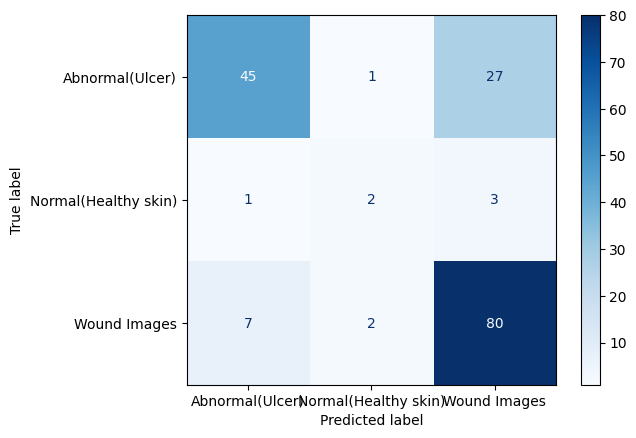

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
labels = test_ds.class_names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [29]:
model.save("modelEFN2.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
